In [1]:
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import timeit
import pandas as pd

In [2]:
config = tf.ConfigProto()
config.intra_op_parallelism_threads = 44
config.inter_op_parallelism_threads = 44

In [3]:
filenames = []
for file in os.listdir('audio'):
    filenames.append(file)
# filenames[0:2]
print("num of files=",len(filenames),",num of actors=",len(filenames)/16)

num of files= 384 ,num of actors= 24.0


In [4]:
random.shuffle(filenames)

In [5]:
# max, min = 76117, 53310
# start, end = 21000/sampling_rate, 47424/sampling_rate
# wave_length = end-start
num_train = int(len(filenames)*0.7)
num_test = len(filenames) - num_train

In [6]:
# for filename in filenames[:num_train]:
#     data, sampling_rate = librosa.load("audio/" + filename, res_type='kaiser_fast', duration=end, offset=start)
#     print(len(data))

In [7]:
# df = pd.DataFrame(columns=['feature'])
# for index, y in enumerate(filenames):
#     data, sampling_rate = librosa.load("audio/" + filename, res_type='kaiser_fast', duration=end, offset=start)
#     mfccs = np.mean(librosa.feature.mfcc(y=data, n_mfcc=25,), axis=0)
#     data_x_train.append(-(mfccs)/100)
    
# df

In [8]:
data_x_train = []
data_x_test = []

start_time = timeit.default_timer()
for filename in filenames[:num_train]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_train.append(mfccs)
    
for filename in filenames[num_train:]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_test.append(mfccs)
    
stop_time = timeit.default_timer()
print('runtime: ', stop_time - start_time)  

runtime:  48.747160666314905


In [9]:
data_y_train = []
data_y_test = []

for filename in filenames[:num_train]:
    if filename[7] == '3':
        data_y_train.append(1)
    elif filename[7] == '4':
        data_y_train.append(0)
        
for filename in filenames[num_train:]:
    if filename[7] == '3':
        data_y_test.append(1)
    elif filename[7] == '4':
        data_y_test.append(0)   

In [10]:
# takes every value in data_y to an array
# ex: [0, 1, 1, 1, 0] => [[0], [1], [1], [1], [0]]
data_y_train_correct = []
data_y_test_correct = []

for val in data_y_train:
    val_arr = []
    val_arr.append(val)
    data_y_train_correct.append(val_arr)
    
for val in data_y_test:
    val_arr = []
    val_arr.append(val)
    data_y_test_correct.append(val_arr)

In [11]:
data_xy_train = []
for i in range(len(data_x_train)):
    data_xy_train.append( (data_x_train[i], data_y_train_correct[i]) )
    
data_xy_test = []
for i in range(len(data_x_test)):
    data_xy_test.append( (data_x_test[i], data_y_test_correct[i]) )

In [12]:
def getXvalues(data_xy):
    x_values = []
    for data in data_xy:
        x_values.append(data[0])
    return x_values

def getYvalues(data_xy):
    y_values = []
    for data in data_xy:
        y_values.append(data[1])
    return y_values

In [13]:
def logistic_fun(z):
    return 1/(1.0 + np.exp(-z))

In [14]:
data_xy_train[1]

(array([-49.56826102, -49.56826102, -49.56826102, -49.56826102,
        -49.56826102, -49.56826102, -49.56570076, -49.92023195,
        -49.64841859, -48.13173906, -47.13205226, -46.72747176,
        -47.54985101, -47.07444249, -45.27361108, -44.49747418,
        -44.3884471 , -43.23060548, -44.62978961, -42.06948306,
        -40.29454054, -40.87143707, -38.6569305 , -39.12723085,
        -39.53263837, -40.45077194, -42.30103939, -44.07920231,
        -44.03932673, -44.92372123, -47.12762379, -48.23363682,
        -48.32664363, -48.5501703 , -49.57411865, -49.76932812,
        -49.69066792, -49.69868061, -49.68178889, -49.73728373,
        -49.65654857, -49.56826102, -49.56826102, -49.56826102,
        -48.58948751, -43.74744117, -37.08622309, -39.42373168,
        -45.32297341, -44.93269207, -44.55556809, -45.16228556,
        -42.09744332, -40.19310538, -38.88011275, -41.39557169,
        -43.38491485, -42.11446293, -43.63233021, -45.70241923,
        -46.77203215, -46.36425714, -47.

In [61]:
features = len(data_xy_train[0][0])
eps = 1e-12

x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.zeros([features,1]))
b = tf.Variable(tf.zeros([1]))
y = 1 / (1.0 + tf.exp(-(tf.matmul(x,W) + b)))

loss1 = -(y_ * tf.log(y + eps) + (1 - y_) * tf.log(1 - y + eps))
loss = tf.reduce_mean(loss1)
update = tf.train.GradientDescentOptimizer(0.00002).minimize(loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

loss_history_train = []
loss_history_test = []
accuracy_history = []

start_time = timeit.default_timer()

for i in range(0,200):
    sess.run(update, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)}) #BGD
    loss_history_train.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)})))
    random.shuffle(data_xy_train)
    
    if i%10 == 0:
        right = 0
        for i in range(len(data_x_test)):
            pred = logistic_fun(np.matmul(getXvalues(data_xy_train)[i],sess.run(W)) + sess.run(b))
            loss_history_test.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_test), y_:getYvalues(data_xy_test)})))
            if data_y_test[i] == 0 and pred < 0.5:
                right += 1
            if data_y_test[i] == 1 and pred > 0.5:
                right += 1
        accuracy_history.append(right/num_test)

stop_time = timeit.default_timer()
print('runtime: ', stop_time - start_time)  

runtime:  7.516774832601982


In [62]:
# data_x_train =          [arr1, arr2, arr3]       # data_x_test = [arr4, arr5]
# shuffle(data_x_train) = [arr2, arr3, arr1]
# data_y_train = [0, 1, 1] # data_y_test = [0, 1]

right = 0

for i in range(len(data_x_test)):
    pred = logistic_fun(np.matmul(getXvalues(data_xy_train)[i],sess.run(W)) + sess.run(b))
    if data_y_test[i] == 0 and pred < 0.5:
        right += 1
    if data_y_test[i] == 1 and pred > 0.5:
        right += 1
#     print("pred:",pred,"=",np.round(pred),"true:",data_y_test[i],"right:",right)

In [63]:
#with happy/sad files from first 4 actors we got 6 out of 20 correct, 30%
#with happy/sad files from first 8 actors we got 15 out of 39 correct, 38.46153846153847%
print("right:",right,",total:",num_test,",accuracy:",right/num_test)

right: 54 ,total: 116 ,accuracy: 0.46551724137931033


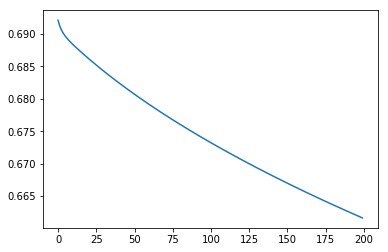

In [64]:
plt.plot(loss_history_train)

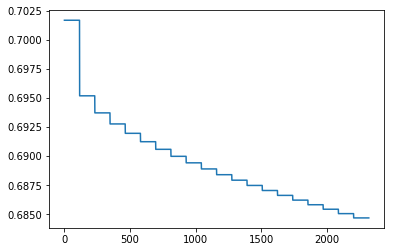

In [65]:
plt.plot(loss_history_test)

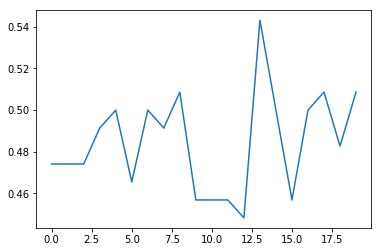

In [66]:
plt.plot(accuracy_history)